import numpy as np
from scipy import constants
from scipy.optimize import leastsq
import uncertainties
from uncertainties import unumpy as unp
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
@uncertainties.wrap
def f(n=0, *P):
    ''' compute the nth root of the polynomial P and the uncertainty of the root'''
    p =  np.array(P)
    N = len(p)
    
    M = np.diag(np.ones((N-2,), p.dtype), -1)
    M[0, :] = -p[1:] / p[0]
    r = np.linalg.eigvals(M)
    r.sort()  # there is no telling what order the values come out in
    return r[n]

Molar masses

In [4]:
N0 = 70
M = {
    'P':31, 'N':14, 'C':12, 'O':8, 'H':1, 
    'F':19, 'Cl':35.5, 'Br':80, 'I':127}
M['head_Ph'] = 6 * M['C'] + 5 * M['O'] + 10 * M['H'] + M['P']
M['head_Et'] = 6 * M['C'] + 2 * M['O'] + 11 * M['H']
M['monoBr'] = 5 * M['C'] + 2 * M['O'] + 7 * M['H'] + M['Br']
M['Imidazolium'] = 4 * M['C'] + 6 * M['H'] + 2 * M['N']
M['Pyrrolidinium'] = 5 * M['C'] + 11 * M['H'] + M['N']
for short, full in [('Im', 'Imidazolium'), ('Pyr', 'Pyrrolidinium')]:
    for X in ['F','Cl','Br','I']:
        M['P'+short+X] = M['head_Ph'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])
        M['P'+short+X+'_Et'] = M['head_Et'] + N0 * (M['monoBr'] + M[full] - M['Br'] + M[X])

In [5]:
M

{'Br': 80,
 'C': 12,
 'Cl': 35.5,
 'F': 19,
 'H': 1,
 'I': 127,
 'Imidazolium': 82,
 'N': 14,
 'O': 8,
 'P': 31,
 'PImBr': 17303,
 'PImBr_Et': 17249,
 'PImCl': 14188.0,
 'PImCl_Et': 14134.0,
 'PImF': 13033,
 'PImF_Et': 12979,
 'PImI': 20593,
 'PImI_Et': 20539,
 'PPyrBr': 17513,
 'PPyrBr_Et': 17459,
 'PPyrCl': 14398.0,
 'PPyrCl_Et': 14344.0,
 'PPyrF': 13243,
 'PPyrF_Et': 13189,
 'PPyrI': 20803,
 'PPyrI_Et': 20749,
 'Pyrrolidinium': 85,
 'head_Et': 99,
 'head_Ph': 153,
 'monoBr': 163}

Other constants

In [6]:
T = constants.C2K(25) #temperature
b = 0.26e-9 # monomer size
lB = 0.7e-9 #Bjerum length
u = lB/b

From now on, in dissociation order: PImBr, PImI, PPyrCl, PPyrBr, PPyrI

Monomer number density for a weight fraction of 80 g/kg

In [7]:
names = ['PImBr', 'PImI', 'PPyrCl', 'PPyrBr', 'PPyrI']
w = 80
c = N0 * constants.N_A / np.array([M[s] for s in names]) * 80 * 1000

Load strain sweeps at $f=1$ Hz.

In [8]:
sweeps = [
    np.loadtxt('ImBr_70_PO3_8pc_bis.strain', skiprows=5, usecols=[4,6,7]),
    np.loadtxt('PImI0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyCl0CL70unit_80gperL.strain', skiprows=2),
    np.loadtxt('PPyBr_70_0pc.strain', skiprows=5, usecols=[4,6,7])[:20],
    np.loadtxt('PPyI0CL70unit_80gperL_bis.strain', skiprows=5, usecols=[4,6,7]),
    ]

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


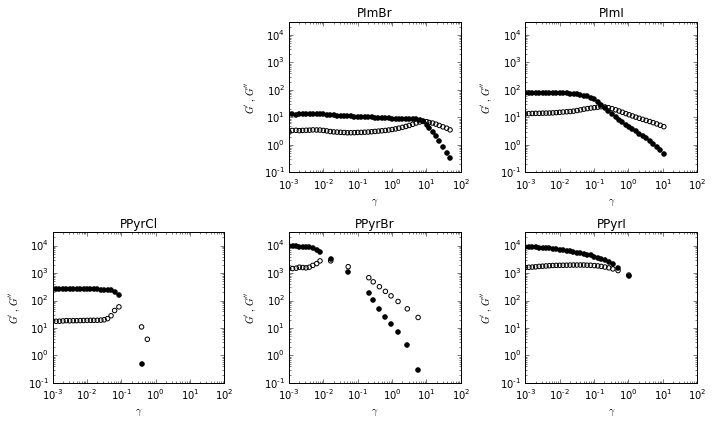

In [9]:
plt.figure(figsize=(10,6))
for i,(a,name) in enumerate(zip(sweeps,names)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.scatter(a[:,0], a[:,1], facecolors='k')
    plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime,\, G^{\prime\prime}$')
plt.tight_layout()

All 5 samples are solidlike ($G^\prime \gg G^{\prime\prime}$) at small strains and flow at large strains ($G^{\prime\prime} \gg G^\prime$) with a steep decrease of the moduli. Moderatly charged PImI and PPyrCl show a plateau in both moduli at low strain corresponding to the linear regime of the material; an overshoot of $G^{\prime\prime}$ and a downward slope of $G^\prime$ at intermediate strains corresponding to the onset of plasticity~\cite{Hyun2011}; and a decrease of both moduli at large strains, steeper for $G^\prime$ than for $G^{\prime\prime}$, indicating shear thinning. The linear regime is either extremely narrow or non existent in heavily charged PPyrBr and PPyrI. By contrast the lightly charged PImBr displays a broad intermediate regime (tree decades of strain) between the linear regime and the crossing of the moduli.

Measure $G'(\gamma \rightarrow 0)$ and the error

In [47]:
G = unp.uarray(
    [a[0,1] for a in sweeps],
    np.abs([(a[0,1]-a[1,1])/2 for a in sweeps])
)
for name, g in zip(names, G):
    print('{}:\tG\' = {:10.4P} Pa\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	G' =      13.28±      0.19 Pa	relative error: 1.43%
PImI:	G' =      78.56±      0.13 Pa	relative error: 0.17%
PPyrCl:	G' =      272.3±       0.6 Pa	relative error: 0.20%
PPyrBr:	G' =       9811±        40 Pa	relative error: 0.40%
PPyrI:	G' =       8796±        34 Pa	relative error: 0.38%


Measure the critical strain $\gamma_c$ such that the moduli cross, and the error.

In [11]:
imaxs = np.array([np.where(a[:,2]<a[:,1])[0][-1] for a in sweeps])
gamma_c = unp.uarray(
    np.exp([
        np.interp(0, np.log(a[imax:imax+2,2]/a[imax:imax+2,1]), np.log(a[imax:imax+2,0])) 
        for a,imax in zip(sweeps, imaxs)
        ]),
    [(a[imax+1,0]-a[imax,0])/2 for a,imax in zip(sweeps, imaxs)]
    )
for name, g in zip(names, gamma_c):
    print('{}:\tgamma_c\' = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	gamma_c' =        8.1±       1.0	relative error: 12.88%
PImI:	gamma_c' =      0.184±     0.024	relative error: 13.11%
PPyrCl:	gamma_c' =       0.12±      0.15	relative error: 124.44%
PPyrBr:	gamma_c' =      0.022±     0.018	relative error: 82.26%
PPyrI:	gamma_c' =       0.89±      0.26	relative error: 29.38%


Estimate the end of the linear regime.

In [12]:
#i0 = np.array([np.where((a[:,2] > 1.15 *a[:np.argmax(a[:,2]),2].min()) & (a[:,1] < 0.95 * a[0,1].max()))[0][0] for a in sweeps])
i0 = np.array([10, 12, 14, 5, 0])
gamma_c0 = unp.uarray(
    [np.exp((np.log(a[imax,0])+np.log(a[imax+1,0]))/2) for a,imax in zip(sweeps, i0)],
    [(a[imax+1,0]-a[imax,0])/2 for a,imax in zip(sweeps, i0)]
    )
for name, g in zip(names, gamma_c0):
    print('{}:\tgamma_c0\' = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	gamma_c0' =     0.0112±    0.0013	relative error: 11.35%
PImI:	gamma_c0' =     0.0179±    0.0020	relative error: 11.16%
PPyrCl:	gamma_c0' =     0.0283±    0.0032	relative error: 11.21%
PPyrBr:	gamma_c0' =     0.0035±    0.0004	relative error: 10.95%
PPyrI:	gamma_c0' =    0.00113±   0.00013	relative error: 11.45%


/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


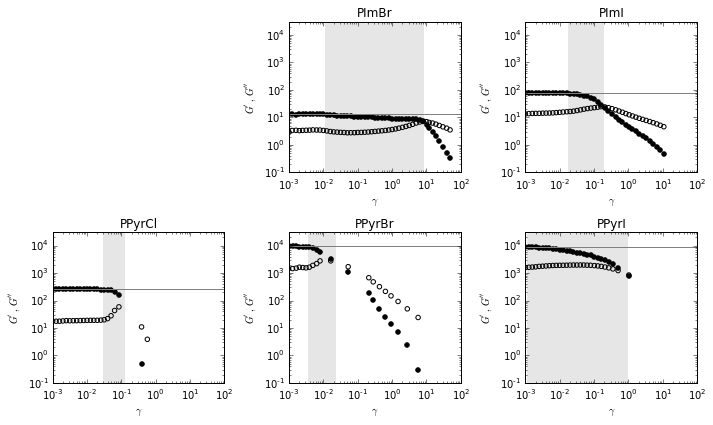

In [13]:
plt.figure(figsize=(10,6))
for i,(a,name, gc0, gc) in enumerate(zip(sweeps,names, gamma_c0, gamma_c)):
    plt.subplot(2,3,2+i)
    plt.title(name)
    plt.axvspan(gc0.n,gc.n, color=(0.9,0.9,0.9), zorder=-1)
    plt.axhline(a[0,1],color=[0.5]*3)
    plt.scatter(a[:,0], a[:,1], facecolors='k')
    plt.scatter(a[:,0], a[:,2], edgecolors='k', facecolors='none')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime,\, G^{\prime\prime}$')
plt.tight_layout()

## Linear regime till the end

In absence of strain, the structure of a polyelectrolyte chain is organised at various scales.

In bad solvent, the monomers tend to attract each other at short range. However at long range there is electrostatic repulsion. The two effects balance at a scale $D$, the size of the so called _electrostatic blob_ containing $g_e$ monomers. We define the extension parameter $B$ as the ratio between the length of a chain of $g_e$ monomers fully extended and the actual size of the electrostatic blob: $$B = \frac{g_e b}{D}$$ where $b$ is the size of a monomer. We want to evaluate $B$ since it is monotonically related to the amount of counterion condensation (at constant solvent quality).

Electrostatic repulsion decays with a characteristic length $r_\mathrm{src}$, the screening length. In general this screening length is set by the concentration of dissociated counterions and the concentration of $c_s$ added salts.
Between $D$ and $r_\mathrm{src}$ the electrostatic blobs are organised in a linear rod containing $g_\mathrm{src}$ monomers. The length of this rod is $B$ times shorter than if the electrostatic blobs were extended: $r_\mathrm{src} = g_\mathrm{src} b/B$

The last length scale is the correlation length $\xi$. Between $r_\mathrm{src}$ and $\xi$ the chain forms a self avoiding walk of persistence length $r_\mathrm{src}$.

Above the correlation length the polyelectrolyte chain forms a random walk of correlation blobs containing $g=c\xi^3$ monomers.

A chain perfoming a random walk or self avoiding walk can be considered an entropic spring of constant stiffness $k_\mathrm{B}T$. The number density of chains is $c/N$ with $c$ the monomer concentration and $N=n N_0$ the number of monomers between cross-links or entanglements. Therefore, the shear modulus at low strain is given by:
$$G = \frac{c}{N}k_\mathrm{B}T.$$

Conversly, we extract the number $n$ of polymers between crosslinks or entanglements from $G'(\gamma \rightarrow 0)$.

In [14]:
T = constants.C2K(25)
n = c/N0 * constants.k * T / G
for name, g in zip(names, n):
    print('{}:\tn = {:10P}\trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	n =        863±        12	relative error: 1.43%
PImI:	n =     122.59±      0.20	relative error: 0.17%
PPyrCl:	n =      50.58±      0.10	relative error: 0.20%
PPyrBr:	n =      1.154±     0.005	relative error: 0.40%
PPyrI:	n =      1.084±     0.004	relative error: 0.38%


As the material is strained, the random walk is stretched, then the self-avoiding walk. When the correlation blobs are fully streched, the chain is a linear assembly of electrostatic blobs. Stretching the chain further means exposing more monomer to the solvent, a process that cannot be reduced to spring of constant stiffness. This condition is thus the limit between the linear and non linear regimes.

For all our samples, the linear regime is narrow $\gamma_0\approx 10^{-2}\ll 1$ if existing. It means that the self-avoiding walk is very short and the random walk probably non existent (the chain is too short). In other words the number $N$ of monomer between crosslinks is comparable to $g_\mathrm{scr}$.

Following\cite{Rubinstein1996} the screening length is
$$r_\mathrm{src} = \left(\frac{B}{cb}\right)^{1/2} \left(1 + Bu \frac{c_s}{c}\right)^{-1/2}$$
from which we deduce the number of monomers in the rod 
$$g_\mathrm{src} = B \frac{r_\mathrm{src}}{b} = \left(\frac{B^3}{cb^3}\right)^{1/2} \left(1 + Bu \frac{c_s}{c}\right)^{-1/2}.$$

Let us note
$$B_s = \frac{c}{u c_s}$$
$$B_0 = b c^{1/3} N^{2/3} = bc \left(\frac{k_\mathrm{B}T}{G}\right)^{2/3}$$

The condition $g_\mathrm{src}\approx N$ writes
$$\left(\frac{B}{B_0}\right)^3 = 1 + \frac{B}{B_s}$$

This equation can be solved numerically to yield B. Nonetheless, we identify two physically relevant limit cases:

- if $B \ll B_s$ (low salt condition) then $B = B_0$

- if $B \gg B_s$ (high salt condition) then $B = \left(\frac{B_0^3}{B_s}\right)^{1/2} > B_0$

Here, the "salt" are the phosphonate heads, that is to say two charges per chain. Thus $c_s/c = 2/N_0$.

In [15]:
Bs = N0/u/2
print('Bs = {:f}'.format(Bs))

Bs = 13.000000


In [48]:
print('Supposing low salt')
B0 = b * c * (constants.k * T / G)**(2/3)
for name, g in zip(names, B0):
    print('{}:\tB0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

Supposing low salt
PImBr:	B0 =      232.1±       2.2 	relative error: 0.95%
PImI:	B0 =      59.62±      0.07 	relative error: 0.11%
PPyrCl:	B0 =      37.23±      0.05 	relative error: 0.13%
PPyrBr:	B0 =      2.806±     0.008 	relative error: 0.27%
PPyrI:	B0 =      2.541±     0.006 	relative error: 0.25%


In [49]:
print('Supposing high salt')
for name, g in zip(names, (B0**3 / Bs)**(1/2)):
    print('{}:\tB1 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

Supposing high salt
PImBr:	B1 =        981±        14 	relative error: 1.43%
PImI:	B1 =     127.68±      0.21 	relative error: 0.17%
PPyrCl:	B1 =      63.01±      0.13 	relative error: 0.20%
PPyrBr:	B1 =      1.304±     0.005 	relative error: 0.40%
PPyrI:	B1 =      1.123±     0.004 	relative error: 0.38%


Numerical solution

In [50]:
B = np.array([
        f(2, 1/(b0**3),0,-1/Bs,-1)
        for b0 in B0
        ])
for name, g in zip(names, B):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =        987±        14 	relative error: 1.42%
PImI:	B =     133.74±      0.21 	relative error: 0.16%
PPyrCl:	B =      68.71±      0.13 	relative error: 0.19%
PPyrBr:	B =      3.008±     0.009 	relative error: 0.29%
PPyrI:	B =      2.706±     0.007 	relative error: 0.27%


/home/mathieu/anaconda3/lib/python3.5/site-packages/uncertainties/core.py:1538: ComplexWarning: Casting complex values to real discards the imaginary part
  self._nominal_value = float(nominal_value)


For the same quality of solvent $B$ is monotonically related to the amount of counterion condensation. We thus confirm that our samples are sorted by decreasing counterion condensation (decreasing $B$). More quantitatively, the number $A$ of monomers between dissociated charges is
$$A = u^{1/2} \left(\frac{B}{\tau}\right)^{3/4} \Leftrightarrow B = \left(\frac{A^2}{u}\right)^{2/3}\tau$$
where $u = b/\ell_\mathrm{B}$, with $\ell_\mathrm{B} = 0.7$ nm the Bjerrum length in water and $\tau = 1-T/\Theta$ the reduced temperature. 

We know that $\Theta>100$°C so $0.2<\tau<1$. In the following we will deduce a more precise measure of $\tau$ and thus values of $A$.

## Extention of the electrostatic blobs

If we neglect the extension of the self-avoiding walk, appying a strain $\gamma$ to the material implies stretching the rod to a length $R = (\gamma+1)N b /B$ and thus exposing more monomers to the solvent. The maximum extention is reached for $R = Nb$ or $\gamma+1=B$.

In [19]:
gamma_c+1 < B

array([ True,  True,  True,  True,  True], dtype=bool)

Following~\cite{Rubinstein1996}, the stretching energy per chain in this situation is 
$$E = \left(\frac{\tau^3 N R}{b}\right)^{1/2} k_\mathrm{B}T = N \left(\gamma+1\right)^{1/2} \left(\frac{\tau^3}{B}\right)^{1/2} k_\mathrm{B}T$$

If we consider that the head-to-body bonds break at $\gamma_c$, we can express the reduced temperature as
$$\tau = \left(\frac{B}{\gamma_c+1}\right)^{1/3} \left(\frac{E_c}{N k_\mathrm{B}T}\right)^{2/3}$$
where $E_c$ is the energy of the head-to-body bond.

The head-to-body bond consists in two ionic bonds, each typically $5\pm 1$ kJ/mol in water\cite{Schneider1992}, thus $E_c\approx 4 k_\mathrm{B}T$. However the medium surrounding the ionic bond is not water. One has to keep in mind that the chain is in bad solvent, thus forming locally compact blobs of low water content. Such a low polarity microenvironement is well known to enhance otherwise weak electrostatic interactions in protein folding or engineered self-assembly\cite{Rehm2010}. We thus expect stronger head-to-body bonds when $B$ is large and the low-polarity environement is extended. A contrario, the weakest ionic links, closest to their strength in water, should be found in \ce{PPyr+I-} where $B$ is minimum.

In [39]:
Ec0 = uncertainties.ufloat(5e3,1e3)*2 / (constants.N_A* constants.k * T)
print('bonding energy {:P} kT'.format(Ec0))
tau = (B[-2]/(1+gamma_c[-2]))**(1/3) * (Ec0 / (n[-2]*N0))**(2/3)
print('tau = {:P}\trelative error: {:0.2f}%\tTheta >= {:P} °C'.format(
        tau,
        100*tau.s/tau.n, 
        constants.K2C(T/(1-tau))
    ))

bonding energy 4.0±0.8 kT
tau = 0.194±0.026	relative error: 13.35%	Theta >= 97±12 °C


In [40]:
(B/(1+gamma_c))**(1/3) * (Ec0 / (n*N0))**(2/3)

array([0.007856652366353897+/-0.0010903507144980232,
       0.029226728800528533+/-0.0039019824081447008,
       0.04300097527711802+/-0.006051048472542657,
       0.19429878301208447+/-0.02593432347962053,
       0.15935641332454809+/-0.022485023284557155], dtype=object)

Using this value of $\tau$ for both PPyr+X- and PIm+X-, we can estimate the binding energies:

In [51]:
Ec = n*N0 * ((gamma_c+1) * tau**3 / B)**(1/2)
for name, g in zip(names, Ec):
    print('{}:\tE_c = {:10.3P} kT = {:10.4P} kJ/mol \trelative error: {:0.2f}%'.format(
            name, g, 
            g * constants.k * T * constants.N_A / 1000,
            100*g.s/g.n))

PImBr:	E_c =        496±       104 kT =       1230±       257 kJ/mol 	relative error: 20.89%
PImI:	E_c =       69.1±      13.9 kT =      171.4±      34.4 kJ/mol 	relative error: 20.05%
PPyrCl:	E_c =       38.7±       8.2 kT =      96.05±     20.29 kJ/mol 	relative error: 21.13%
PPyrBr:	E_c =       4.03±      0.81 kT =      10.00±      2.00 kJ/mol 	relative error: 20.00%
PPyrI:	E_c =       5.43±      1.15 kT =      13.46±      2.85 kJ/mol 	relative error: 21.19%


The estimated binding energy for PIm+Br- reaches unphysical values, larger than the carbon-carbon single bond (350 kJ/mol or $140 k_\mathrm{B}T$). We may suppose a smaller $\tau$ for the Immidazolium-based polymer.

In [60]:
for name, g in zip(names, n[:2]*N0 * ((gamma_c[:2]+1) * 0.2**3 / B[:2])**(1/2)):
    print('{}:\tE_c = {:10.3P} kT = {:10.3P} kJ/mol \trelative error: {:0.2f}%'.format(
            name, g, 
            g * constants.k * T * constants.N_A / 1000,
            100*g.s/g.n))

PImBr:	E_c =        518±        30 kT =   1.28×10³±  0.07×10³ kJ/mol 	relative error: 5.78%
PImI:	E_c =       72.2±       0.7 kT =        179±         2 kJ/mol 	relative error: 1.02%


In [58]:
2**(1/4)

1.189207115002721

## Case of PPyrI

Heavily charged PPyrI has a single chain between crosslinks. A single 70 units chain is probably shorter than the screening length $r_\mathrm{src}$, so at rest the polyelectroylte is a rod of length $L = N_0 b / B$ where $b\approx 0.26$ nm is the monomer size and $B$ is the extension parameter. The rod is itself made of electrostatic blobs whoes size $D$ is set by the balance between short range attraction between monomers due to poor solvent quality and the electrostatic repulsion.

Following~\cite{Rubinstein1996}, in low salt conditions we have 
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)$$

Thus the condition $r_\mathrm{scr} \geq L$ translates to
$$B \geq b c^{1/3} N_0^{2/3}$$

In [131]:
print('B >= {:0.2f}'.format(b * c[-1]**(1/3) * N0**(2/3)))

B >= 2.41


Appying a strain $\gamma$ to the material implies stretching chains to a length $R = (\gamma+1)N_0 b /B$ and thus exposing more monomers to the solvent. Following~\cite{Rubinstein1996}, the stretching energy per chain in this situation is 
$$E = \left(\frac{\tau^3 N R}{b}\right)^{1/2} k_\mathrm{B}T = N \left(\gamma+1\right)^{1/2} \left(\frac{\tau^3}{B}\right)^{1/2} k_\mathrm{B}T$$
where $\tau = 1 - T/\Theta$ is the reduced temperature.

The head-to-body bond consists in two ionic bonds, each typically $5 k_\mathrm{B}T$. If we consider that they break around $\gamma_c$, we can write
$$\tau = \left(B\left(\gamma_c+1\right)\right)^{1/3} \left(\frac{E}{N k_\mathrm{B}T}\right)^{2/3}$$

In [132]:
tau = (2.41*(1+gamma_c[-1]))**(1/3) * (10 / (n[-1]*N0))**(2/3)
print('tau >= {:P}\trelative error: {:0.2f}%\tTheta >= {:P} °C'.format(
        tau,
        100*tau.s/tau.n, 
        constants.K2C(T/(1-tau))
    ))

tau >= 0.429±0.020	relative error: 4.62%	Theta >= 249±18 °C


In [137]:
print('Maximum extension is B = {} > 1+gamma_c = {:P}'.format(2.41, 1+gamma_c[-1]))

Maximum extension is B = 2.41 > 1+gamma_c = 1.89±0.26


There is a charge every A monomers.

In [134]:
print('with B = {:0.2f}, A = {:P}'.format(2.41, u**(1/2) * (2.41/tau)**(3/4)))

with B = 2.41, A = 5.98±0.21


### Estimation of extension parameter $B$

In abscence of salt, the screening length and the correlation lengths are equal. Above this length, the polyelectrolyte makes a random walk composed of linear blobs containing $g_\mathrm{src}$ monomer.

$$g_\mathrm{src} = g_e \frac{r_\mathrm{src}}{D} = \left(\frac{B^3}{cb^3}\right)^{1/2}$$.

The exit from the linear domain of the material corresponds to the full extension of the persistent random walk:
$$\gamma_0 = \frac{R_0}{R} - 1,$$
with
$$\left. \begin{array}{ll}
R &= r_\mathrm{scr} \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2}\\
R_0 &= r_\mathrm{scr} \frac{N}{g_\mathrm{scr}}
\end{array}\right\rbrace\quad
\gamma_0 = \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2} -1
$$

Finally
$$B = \left(b^3 c \frac{N^2}{(\gamma_0+1)^4}\right)^{1/3} = bc \left(\frac{k_\mathrm{B}T}{G\left(\gamma_0+1\right)^2}\right)^{2/3}$$

In [139]:
B = b * c * (constants.k * T / G / (gamma_c0+1)**2)**(2/3)
for name, g in zip(names, B):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =      228.7±       2.2 	relative error: 0.97%
PImI:	B =      58.23±      0.17 	relative error: 0.28%
PPyrCl:	B =      35.87±      0.16 	relative error: 0.43%
PPyrBr:	B =      2.793±     0.008 	relative error: 0.27%
PPyrI:	B =      2.537±     0.006 	relative error: 0.25%


If head-to-body bonds break within the linear regime of the chain, the bonding energy can be deduced from the critical strain:
$$\frac{E_c}{k_\mathrm{B}T} = \gamma_c^2$$

In [10]:
for name, g in zip(names, gamma_c**2):
    print('{}:\tE_c = {:10P} kT = {:10.3P} kJ/mol \trelative error: {:0.2f}%'.format(
            name, g, 
            g * constants.k * T * constants.N_A / 1000,
            100*g.s/g.n))

PImBr:	E_c =         81±        19 kT =        202±        47 kJ/mol 	relative error: 23.06%
PImI:	E_c =      0.032±     0.009 kT =     0.0802±    0.0215 kJ/mol 	relative error: 26.81%
PPyrCl:	E_c =       0.03±      0.05 kT =      0.082±     0.136 kJ/mol 	relative error: 166.64%
PPyrBr:	E_c =     0.0009±    0.0011 kT =    0.00214±   0.00265 kJ/mol 	relative error: 123.76%
PPyrI:	E_c =     0.0020±    0.0004 kT =    0.00488±   0.00111 kJ/mol 	relative error: 22.66%


Only PImBr has $E_c>k_\mathrm{B}T$.

### Estimation of extension parameter $B$

In abscence of salt, the screening length is
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}$$
where $b\approx 0.26$ nm is the monomer size and $B$ is the extension parameter
$$B = \frac{b g_e}{D} = \frac{b g_\mathrm{src}}{r_\mathrm{src}}$$
describes the electrostatic blob of diameter $D$ containing $g_e$ monomers. Between $D$ and $r_\mathrm{scr}$ the polyelectrolyte is a linear assembly of electrostatic blobs, thus
$$g_\mathrm{src} = g_e \frac{r_\mathrm{src}}{D} = \left(\frac{B^3}{cb^3}\right)^{1/2}$$.

The exit from the linear domain of the material corresponds to the full extension of the persistent random walk:
$$\gamma_c = \frac{R_0}{R} - 1,$$
with
$$\left. \begin{array}{ll}
R &= r_\mathrm{scr} \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2}\\
R_0 &= r_\mathrm{scr} \frac{N}{g_\mathrm{scr}}
\end{array}\right\rbrace\quad
\gamma_c = \left(\frac{N}{g_\mathrm{scr}}\right)^{1/2} -1
$$

Finally
$$B = \left(b^3 c \frac{N^2}{(\gamma_c+1)^4}\right)^{1/3} = bc \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c+1\right)^2}\right)^{2/3}$$

#### Narrow linear regime
For $\gamma_c \ll 1$ the extension parameter is almost independent of $\gamma_c$. At 0th order
$$B \approx bc \left(\frac{k_\mathrm{B}T}{G}\right)^{2/3}$$

In [11]:
B0 = b * c * (constants.k * T / G)**(2/3)
for name, g in zip(names, B0):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =      232.1±       2.2 	relative error: 0.95%
PImI:	B =      59.62±      0.07 	relative error: 0.11%
PPyrCl:	B =      37.23±      0.05 	relative error: 0.13%
PPyrBr:	B =      2.806±     0.008 	relative error: 0.27%
PPyrI:	B =      2.541±     0.006 	relative error: 0.25%


Full calculation would be necessary for PImBr, but we set it aside because head-to-body link broke before full extension of the persistent random walk

In [10]:
b = 0.26e-9
B = b * c * (constants.k * T / G / (gamma_c+1)**2)**(2/3)
for name, g in zip(names, B):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =       10.7±       1.5 	relative error: 13.87%
PImI:	B =       47.8±       1.3 	relative error: 2.73%
PPyrCl:	B =         30±         5 	relative error: 17.08%
PPyrBr:	B =       2.70±      0.06 	relative error: 2.37%
PPyrI:	B =      2.398±     0.017 	relative error: 0.69%


Conversly, 
$$\gamma_c = \left(\frac{N^2 c b^3}{B^3}\right)^{1/4} -1 = \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2}\left(\frac{cb}{B}\right)^{3/4} -1$$

We know that PImBr has even less charges than than PImI, so we assume a $B$ at least equal in PImBr with respect to PImI
$$\gamma_c(\mathrm{PImBr}) < \left(\frac{k_\mathrm{B}T}{G(\mathrm{PImBr})}\right)^{1/2}\left(\frac{c(\mathrm{PImBr})b}{B(\mathrm{PImI})}\right)^{3/4} -1$$

In [11]:
g = (constants.k * T / G[0])**(1/2) * (c[0] * b / B[1])**(3/4)-1
print('gamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

gamma_c_max = 2.27±0.07	relative error:  3.12%
but gamma_c = 9.0±1.0


Therefore PImBr has a linear regime much larger than what we expect.

### Estimation of the charge density

From the extension parameter $B$ and provided an assumption on the $\Theta$-temperature, we can deduce the number $A$ of monomers between dissociated charges. If $A=1$, there is no counterion condensation and the polyelectrolyte is fully charged.
$$B = \left(\frac{A^2}{u}\right)^{2/3}\tau \Leftrightarrow A = u^{1/2} \left(\frac{B}{\tau}\right)^{3/4}$$
where $u = b/\ell_\mathrm{B}$, with $\ell_\mathrm{B} = 0.7$ nm the Bjerrum length in water and $\tau = 1-T/\Theta$ the reduced temperature. We know that $\Theta>100$C so $0.2<\tau<1$.

In [58]:
lB = 0.7e-9
u = lB/b
tau = 0.2
A = u**(1/2) * (B/tau)**(3/4)
for name, g in zip(names, A):
    print('{}:\tA = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

NameError: name 'B' is not defined

Is it possible to have $A>N_0$?

### Lower bound for $\tau$

for the polymer to be soluble, we want at least a charge per polymer, or $A<N_0$ that yields
$$\tau > \left(\frac{n u}{N_0}\right)^{2/3} \frac{c^{1/3}b}{(\gamma_c+1)^{4/3}}$$

In [13]:
for name, g in zip(names, (n*u/N0)**(2/3) * c**(1/3) * b /(gamma_c+1)**(4/3)):
    print('{}:\ttau_max = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	tau_max =      0.072±     0.010 	relative error: 13.87%
PImI:	tau_max =      0.321±     0.009 	relative error: 2.73%
PPyrCl:	tau_max =      0.200±     0.034 	relative error: 17.08%
PPyrBr:	tau_max =     0.0181±    0.0004 	relative error: 2.37%
PPyrI:	tau_max =    0.01608±   0.00011 	relative error: 0.69%


In [14]:
lB = 0.7e-9
u = lB/b
tau = 0.33
A = u**(1/2) * (B/tau)**(3/4)
for name, g in zip(names, A):
    print('{}:\tA = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	A =       22.4±       2.3 	relative error: 10.40%
PImI:	A =       68.5±       1.4 	relative error: 2.05%
PPyrCl:	A =         48±         6 	relative error: 12.81%
PPyrBr:	A =       7.94±      0.14 	relative error: 1.78%
PPyrI:	A =       7.26±      0.04 	relative error: 0.52%


### Are Phosphonate charges negigible ?

In presence of additional salts in concentration $c_s$, the screening length becomes
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}\left(1 + B u \frac{c_s}{c}\right)^{-1/2}$$

So we have to estimate $B u c_s/c$ relative to 1 with $c_s/c = 2/N_0$.

In [62]:
for name, g in zip(names, (1 + B0*u*2/N0)**(1/2)):
    print('{}:\t {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	      4.342±     0.020 	relative error: 0.45%
PImI:	     2.3635±    0.0011 	relative error: 0.05%
PPyrCl:	     1.9657±    0.0010 	relative error: 0.05%
PPyrBr:	    1.10265±   0.00026 	relative error: 0.02%
PPyrI:	    1.09336±   0.00023 	relative error: 0.02%


### Estimation of extension parameter $B$

When counting the screening from phosphonates, we have to distinguish between the screening length
$$r_\mathrm{scr} = \left(\frac{B}{cb}\right)^{1/2}\left(1 + 2 B u / N_0 \right)^{-1/2}$$
and the correlation length
$$\xi = \left(\frac{B}{cb}\right)^{1/2}\left(1 + 2 B u / N_0 \right)^{1/4}$$
where $b\approx 0.26$ nm is the monomer size and $B$ is the extension parameter
$$B = \frac{b g_e}{D} = \frac{b g_\mathrm{src}}{r_\mathrm{src}}$$
that describes the electrostatic blob of diameter $D$ containing $g_e$ monomers. 

Between $D$ and $r_\mathrm{scr}$ the polyelectrolyte is a linear assembly of electrostatic blobs, thus
$$g_\mathrm{src} = B \frac{r_\mathrm{src}}{b} = \left(\frac{B^3}{cb^3}\right)^{1/2} \left(1 + 2 B u / N_0 \right)^{-1/2}$$

Between the electrostatic screening length and the correlation length $\xi$, the polyelectrolyte chain is a self-avoiding walk. Each correlation blob has $g$ ($=c\xi^3$) monomers in it.
$$g = \left(\frac{B^3}{c b^3}\right)^{1/2} \left(1 + 2 B u / N_0 \right)^{3/4}$$

Beyond the correlation length, the chain statistics are Gaussian. We can thus define a first critical strain corresponding to the full extention of this random walk:
$$\gamma_0 = \frac{R_0}{R} - 1,$$
with
$$\left. \begin{array}{ll}
R &= \xi \left(\frac{N}{g}\right)^{1/2}\\
R_0 &= \xi \frac{N}{g}
\end{array}\right\rbrace\quad
\gamma_0 = \left(\frac{N}{g}\right)^{1/2} -1
$$

The exit from the linear domain of the material corresponds to the full extension of the self avoiding walk of $r_\mathrm{src}$-long rods:
$$\gamma_c = \frac{R_1}{R} - 1,$$
with
$$ R_1 = r_\mathrm{scr} \frac{N}{g_\mathrm{scr}} = D \frac{N}{g_e}$$
thus
$$\gamma_c +1 = \frac{r_\mathrm{scr}}{\xi} \left(\frac{N g}{g_\mathrm{scr}^2}\right)^{1/2} = N^{1/2} \left(\frac{c b^3}{B^3}\right)^{1/4} \left(1 + 2 B u / N_0 \right)^{1/8} = \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2} \left(\frac{c b}{B}\right)^{3/4} \left(1 + 2 B u / N_0 \right)^{1/8}$$

Finally we can solve for B
$$\frac{\left(\gamma_c +1\right)^8}{c^6 b^6}\left(\frac{G}{k_\mathrm{B}T}\right)^4 B^6 = 1 + \frac{2u}{N_0} B$$

In [16]:
N0/(2*u)

12.999999999999998

If $B\ll \frac{N_0}{2u}\approx 13$ phosphonate charges are negligibles and we recover
$$B = c b \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c +1\right)^2}\right)^{2/3}$$

If $B\gg \frac{N_0}{2u}\approx 13$ phosphonate charges are dominant
$$B = \left(cb\right)^{6/5} \left(\frac{2u}{N_0}\right)^{1/5} \left(\frac{k_\mathrm{B}T}{G\left(\gamma_c +1\right)^2}\right)^{4/5}$$

In [17]:
B2 = (b * c)**(6/5) * (2*u/N0)**(1/5) * (constants.k * T / G / (gamma_c+1)**2)**(4/5)
for name, g in zip(names, B2):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =       10.3±       1.7 	relative error: 16.64%
PImI:	B =       62.0±       2.0 	relative error: 3.27%
PPyrCl:	B =         35±         7 	relative error: 20.50%
PPyrBr:	B =       1.97±      0.06 	relative error: 2.85%
PPyrI:	B =      1.710±     0.014 	relative error: 0.83%


In the phosphonate dominated case 
$$\gamma_c +1 \approx \left(\frac{k_\mathrm{B}T}{G}\right)^{1/2} \left(c b\right)^{3/4} \left(\frac{2 u}{N_0} \right)^{1/8} B^{-5/8}$$

We know that PImBr has even less charges than than PImI, so we assume a $B$ at least equal in PImBr with respect to PImI
$$\gamma_c(\mathrm{PImBr}) < \left(\frac{k_\mathrm{B}T}{G(\mathrm{PImBr})}\right)^{1/2} \left(c(\mathrm{PImBr}) b\right)^{3/4} \left(\frac{2 u}{N_0} \right)^{1/8} B(\mathrm{PImI})^{-5/8}-1$$

In [18]:
for name, g in zip(names, (constants.k * T / G[0])**(1/2) * (c[0] * b)**(3/4) * (2*u/N0)**(1/8) / B2**(5/8) - 1):
    print('{}:\tgamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(name,g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

PImBr:	gamma_c_max = 9.0±1.0	relative error:  11.53%
PImI:	gamma_c_max = 2.27±0.07	relative error:  3.12%
PPyrCl:	gamma_c_max = 3.7±0.6	relative error:  16.33%
PPyrBr:	gamma_c_max = 27.2±0.5	relative error:  1.99%
PPyrI:	gamma_c_max = 29.86±0.27	relative error:  0.91%
but gamma_c = 9.0±1.0


Actually solve for $B$

In [19]:
@uncertainties.wrap
def f(n=0, *P):
    ''' compute the nth root of the polynomial P and the uncertainty of the root'''
    p =  np.array(P)
    N = len(p)
    
    M = np.diag(np.ones((N-2,), p.dtype), -1)
    M[0, :] = -p[1:] / p[0]
    r = np.linalg.eigvals(M)
    r.sort()  # there is no telling what order the values come out in
    return r[n]

In [20]:
B3 = np.array([
        f(5, 1,0,0,0,0,-b1**5,-b0**6)
        for b0,b1 in zip(B,B2)
        ])
for name, g in zip(names, B3):
    print('{}:\tB = {:P}'.format(name,g))

PImBr:	B = 12.0±1.8
PImI:	B = 64.4±2.0
PPyrCl:	B = 37±7
PPyrBr:	B = 2.79±0.07
PPyrI:	B = 2.468±0.017


/home/mathieu/anaconda3/lib/python3.5/site-packages/uncertainties/core.py:1538: ComplexWarning: Casting complex values to real discards the imaginary part
  self._nominal_value = float(nominal_value)


In [21]:
for name, g in zip(names, (constants.k * T / G[0])**(1/2) * (c[0] * b)**(3/4) * (2*u/N0)**(1/8) / B3**(5/8) - 1):
    print('{}:\tgamma_c_max = {:P}\trelative error:  {:0.2f}%'.format(name,g,100*g.s/g.n))
print('but gamma_c = {:P}'.format(gamma_c[0]))

PImBr:	gamma_c_max = 8.1±0.9	relative error:  10.55%
PImI:	gamma_c_max = 2.20±0.07	relative error:  3.06%
PPyrCl:	gamma_c_max = 3.5±0.5	relative error:  15.70%
PPyrBr:	gamma_c_max = 21.7±0.4	relative error:  1.76%
PPyrI:	gamma_c_max = 23.53±0.21	relative error:  0.88%
but gamma_c = 9.0±1.0


### Some geometry

In the case $\tau=0.33$, how many monomers are contained in an electrostatic blob ?
$$g_e = \left(\frac{B^3}{\tau}\right)^{1/2}$$

In [45]:
tau=0.33
for name, g in zip(names, (B0**3/tau)**(1/2)):
    print('{}:\tge = {:10.4P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge =       6155±        88 	relative error: 1.43%
PImI:	ge =      801.4±       1.3 	relative error: 0.17%
PPyrCl:	ge =      395.5±       0.8 	relative error: 0.20%
PPyrBr:	ge =      8.182±     0.033 	relative error: 0.40%
PPyrI:	ge =      7.049±     0.027 	relative error: 0.38%


Or in number of chains per electrostatic blobs

In [46]:
for name, g in zip(names, (B0**3/tau)**(1/2) / N0):
    print('{}:\tge/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	ge/N0 =       87.9±       1.3 	relative error: 1.43%
PImI:	ge/N0 =     11.449±     0.019 	relative error: 0.17%
PPyrCl:	ge/N0 =      5.650±     0.011 	relative error: 0.20%
PPyrBr:	ge/N0 =     0.1169±    0.0005 	relative error: 0.40%
PPyrI:	ge/N0 =     0.1007±    0.0004 	relative error: 0.38%


Number of chains in a correlation blob
$$g_\mathrm{scr} = \left(\frac{B^3}{c b^3}\right)^{1/2}$$

In [48]:
for name, g in zip(names, (B0**3/c/b**3)**(1/2) / N0):
    print('{}:\tg_scr/N0 = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	g_scr/N0 =        863±        12 	relative error: 1.43%
PImI:	g_scr/N0 =     122.59±      0.20 	relative error: 0.17%
PPyrCl:	g_scr/N0 =      50.58±      0.10 	relative error: 0.20%
PPyrBr:	g_scr/N0 =      1.154±     0.005 	relative error: 0.40%
PPyrI:	g_scr/N0 =      1.084±     0.004 	relative error: 0.38%


Number of electrostatic blobs per correlation blobs
$$\frac{g_\mathrm{src}}{g_e} = \left(\frac{\tau}{c b^3}\right)^{1/2}$$
Depends only on monomer concentration, not on the rheological measurements

In [25]:
for name, g in zip(names, (tau/c/b**3)**(1/2)):
    print('{}:\tg_scr/ge = {:0.2f}'.format(name,g))

PImBr:	g_scr/ge = 9.81
PImI:	g_scr/ge = 10.71
PPyrCl:	g_scr/ge = 8.95
PPyrBr:	g_scr/ge = 9.87
PPyrI:	g_scr/ge = 10.76


Number of correlation blobs between cross-links
$$\frac{N}{g_\mathcal{scr}} = n N_0 \left(\frac{c b^3}{B^3}\right)^{1/2}$$

In [51]:
for name, g in zip(names, n*N0*(c * b**3/B0**3)**(1/2) / N0):
    print('{}:\tN/g_scr = {:10.4P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	N/g_scr =    0.01429±   0.00000 	relative error: 0.00%
PImI:	N/g_scr =    0.01429±   0.00000 	relative error: 0.00%
PPyrCl:	N/g_scr =    0.01429±   0.00000 	relative error: 0.00%
PPyrBr:	N/g_scr =    0.01429±   0.00000 	relative error: 0.00%
PPyrI:	N/g_scr =    0.01429±   0.00000 	relative error: 0.00%


We know that PImBr has even less charges than than PImI, therefore a larger $A$ and a larger $B$.

$$B(\mathrm{PImBr}) > B(\mathrm{PImI}) 
\Leftrightarrow \frac{c^{1/4} n^{1/2}}{R_0/R}(\mathrm{PImBr}) > \frac{c^{1/4} n^{1/2}}{\gamma_c+1}(\mathrm{PImI})
\Leftrightarrow \frac{R_0}{R}(\mathrm{PImBr}) < \frac{c^{1/4} n^{1/2}(\mathrm{PImBr})}{c^{1/4} n^{1/2}(\mathrm{PImI})}(\gamma_c(\mathrm{PImI})+1)$$

In [27]:
(c[0]/c[1])**(1/4) * (n[0]/n[1])**(1/2) * (gamma_c[1]+1)

3.2700280266277737+/-0.07085980250636678

Instead of $\gamma_c+1 = 9$.

Actually, to get the equality we need 
$$\frac{n_\mathrm{PImBr}}{n_\mathrm{PImI}} = \left(\frac{c_\mathrm{PImBr}}{c_\mathrm{PImI}}\right)^{1/2} \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2 \approx \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2 \approx 81$$ 
and we only have 7.

In [28]:
n[0]/n[1]

7.040469338487859+/-0.10140111983448306

Thinking in terms of fractal dimension, we need an aggregate of dimension $d$ so that

$$\left(\frac{n_\mathrm{PImBr}}{n_\mathrm{PImI}}\right)^d = \left(\frac{c_\mathrm{PImBr}}{c_\mathrm{PImI}}\right)^{1/2} \left(\frac{\gamma_{c,\mathrm{PImBr}}+1}{\gamma_{c,\mathrm{PImI}}+1}\right)^2$$

In [21]:
(np.log(c[0]/c[1]) + 2*np.log(n[0]/n[1]))/np.log((gamma_c[0]+1) / (gamma_c[1]+1)) /2

0.99981846876862512

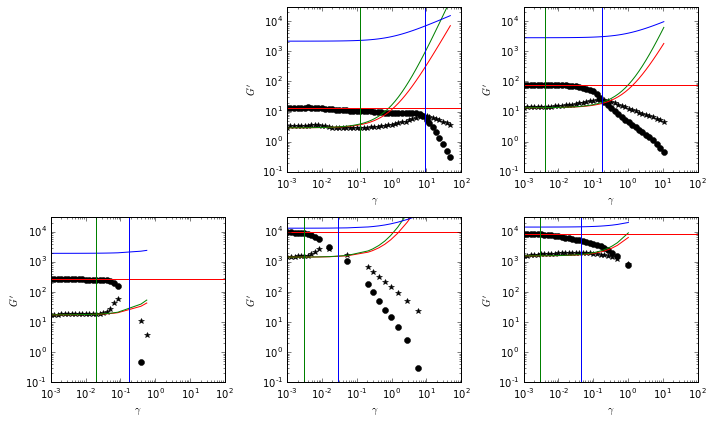

In [31]:
plt.figure(figsize=(10,6))
for i,(a,g,gc,g0,gg) in enumerate(zip(
        sweeps, G,gamma_c, [8e-3,4e-3,2e-2,3e-3,3e-3], 
        (0.33**12 * (n*N0)**6 / (c*b**3*B0))**(1/8)
        )):
    plt.subplot(2,3,2+i)
    plt.plot(a[:,0], a[:,1], 'ko')
    plt.plot(a[:,0], a[:,2], 'k*')
    plt.plot(a[:,0], a[0,2]*(a[:,0]+1)**2, 'r-')
    plt.plot(a[:,0], a[0,2]*(a[:,0]+1)**(5/2), 'g-')
    plt.plot(a[:,0], a[0,2]*(a[:,0]+1)**(1/2)*gg.n, 'b-')
    plt.axhline(g.n, color='r')
    plt.axvline(gc.n, color='b')
    plt.axvline(g0, color='g')
    #plt.plot(a[:,0], g.n*(a[:,0]+1)**(-2), 'r-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime$')
plt.tight_layout()

In [93]:
B4 = b * c * (constants.k * T / G / (np.array([1.25e-1,4e-3,2e-2,3e-3,3e-3])+1)**2)**(2/3)
for name, g in zip(names, B4):
    print('{}:\tB = {:10P} \trelative error: {:0.2f}%'.format(name,g,100*g.s/g.n))

PImBr:	B =      198.4±       1.9 	relative error: 0.95%
PImI:	B =      59.31±      0.07 	relative error: 0.11%
PPyrCl:	B =      36.26±      0.05 	relative error: 0.13%
PPyrBr:	B =      2.795±     0.008 	relative error: 0.27%
PPyrI:	B =      2.531±     0.006 	relative error: 0.25%


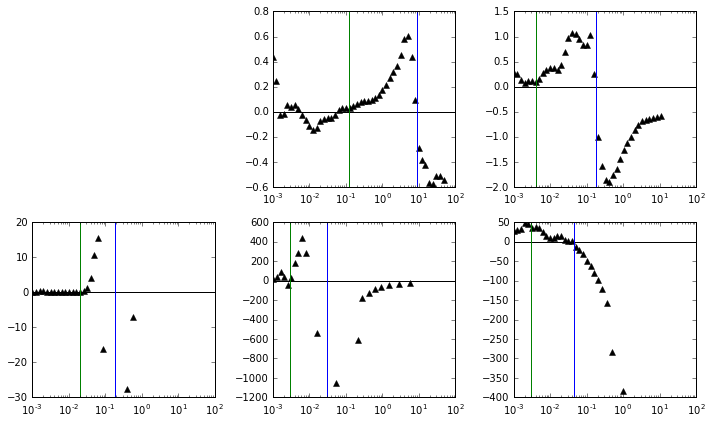

In [25]:
plt.figure(figsize=(10,6))
for i,(a,g,gc,g0) in enumerate(zip(sweeps, G,gamma_c, [1.25e-1,4e-3,2e-2,3e-3,3e-3])):
    plt.subplot(2,3,2+i)
    plt.plot(a[:,0], np.gradient(a[:,2]), 'k^')
    plt.axhline(0, color='k')
    plt.axvline(gc.n, color='b')
    plt.axvline(g0, color='g')
    plt.xscale('log')
    plt.xlim(1e-3,1e2)
plt.tight_layout()

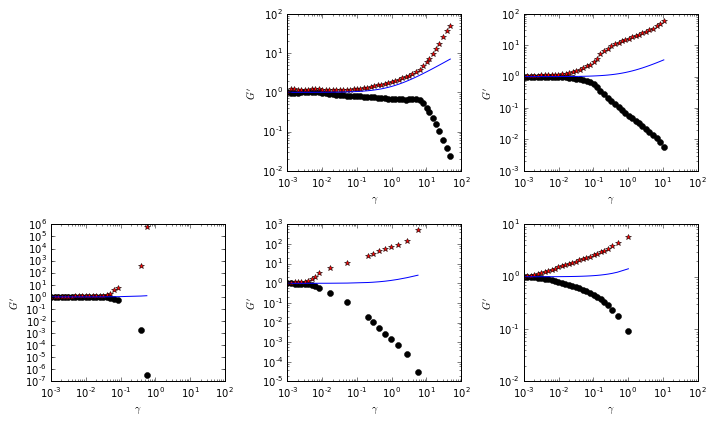

In [56]:
plt.figure(figsize=(10,6))
for i,a in enumerate(sweeps):
    plt.subplot(2,3,2+i)
    gg = np.abs(a[:,1]+1j*a[:,1])
    plt.plot(a[:,0], gg/gg[0], 'ko')
    plt.plot(a[:,0], a[:,2]/a[0,2]/(gg/gg[0]), '*r')
    plt.plot(a[:,0], (a[:,0]+1)**(1/2), 'b-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e2)
    #plt.ylim(1e-1,3e4)
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$G^\prime$')
plt.tight_layout()

### Extention thresholds function of B

$$\begin{array}{rcl}
\gamma_0+1 &=& \left(\frac{N}{g}\right)^{1/2}\\
\gamma_1+1 &=& \left(\frac{N}{g}\right)^{1/2} \left(\frac{g}{g_\mathrm{scr}}\right)^{2/5}\\
\gamma_2+1 &=& \left(\frac{N}{g}\right)^{1/2} \left(\frac{g}{g_\mathrm{scr}}\right)^{2/5} B
\end{array}$$

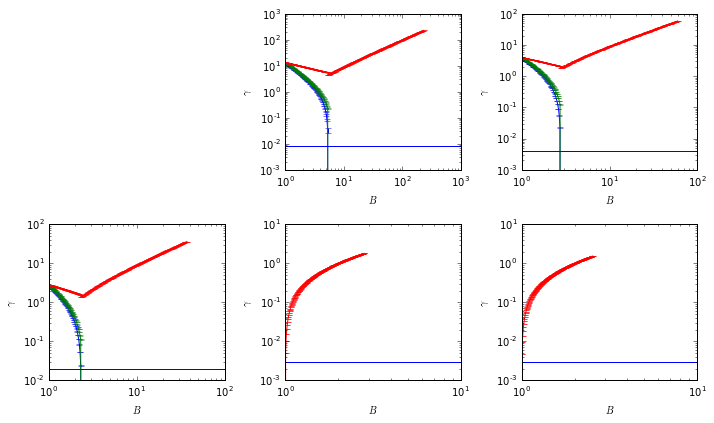

In [101]:
plt.figure(figsize=(10,6))
for i,(BB,nn,cc, gc) in enumerate(zip(B0, n, c, [8e-3,4e-3,2e-2,3e-3,3e-3])):
    plt.subplot(2,3,2+i)
    Bs = np.logspace(0,np.log10(BB.n),200, base=10)
    gamma_0 = (nn*N0 / (Bs**3/(cc*b**3) * (1 + Bs*u*2/N0)**(3/4)))**(1/2) - 1
    gamma_1 = np.where(
        gamma_0>0, 
        (gamma_0+1) * (1 + Bs*u*2/N0)**(1/2),
        ((nn*N0)**2 * b**3 / cc / Bs**3 * (1 + Bs*u*2/N0))**(1/5)
        ) -1
    gamma_2 = np.maximum(1, (gamma_1+1)) * Bs -1
    plt.errorbar(Bs, unp.nominal_values(gamma_0), unp.std_devs(gamma_0))
    plt.errorbar(Bs, unp.nominal_values(gamma_1), unp.std_devs(gamma_1))
    plt.errorbar(Bs, unp.nominal_values(gamma_2), unp.std_devs(gamma_2))
    plt.xlabel(r'$B$')
    plt.ylabel(r'$\gamma$')
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(gc)
    #plt.axvline((b**6 * (nn.n*N0)**4 * N0/ (2*u*cc))**(1/9))
plt.tight_layout()

## Structure from probability distributions

In [22]:
from scipy.stats import binom, poisson

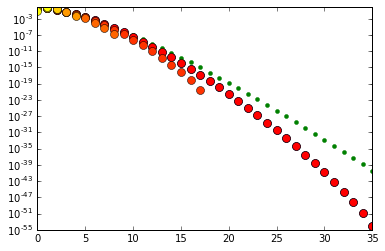

In [23]:
plt.plot(binom.pmf(np.arange(N0/2+1), N0/2, 2/N0), 'bo', ms=8, label='binom pmf')
plt.plot(poisson.pmf(np.arange(N0/2+1), 1), 'g.', ms=8, label='binom pmf')
for i,a in enumerate(2**np.arange(6)):
    plt.plot(binom.pmf(np.arange(N0/a/2+1), N0/a/2, 2*a/N0), 'o', color=plt.cm.autumn(i/5.), ms=8, label='binom pmf')
plt.yscale('log')

If the electrostatic blob cannot contain even the shortest side chain, then every side chain sticks out and thus the branching counts as a cross link. The precise boundary is when the electrostatic blob contains the main chain and a single monomeric side chain $ge<2N_0$. This translates in a condition on $A$ (provided $\tau$):
$$A < A_1 = \left(\frac{2N_0 u}{\tau}\right)^{1/2}$$.

In [24]:
(2*N0*u/np.array([0.2,tau,0.5,1]))**(1/2)

array([ 43.41215711,  33.79631847,  27.45625892,  19.41450687])

Since there is exactly one head per body, the average number of heads attached to a given body is 1. The probability to have a head attached to a monomer is thus $1/N_0$. The probability of having a given number of monomers between crosslinks is thus given by a geometric distribution of parameter $1/N_0$. The average number of monomers between crosslinks is thus $N_0$. Therefore $n=k=1$.

If $A>A_1$, monomeric side chains are able to fully collapse on the main chain and thus do not count as cross-link anymore. The probability to have a crosslink is thus the probability to have a side chain AND that this side chain is not monomeric.

Let us suppose that the probability of attaching a head to a given body is ndependent of the number of heads already attached, with a maximum of $N_0/2A$ heads per body (bivalent phosphonate head need two monovalent cationic groups to attach, and ony $N_0/A$ are available). The probability $P(h)$ of having $h$ heads attached to the same body is thus given by a binomial law of mean 1. The probability to have no head attached and thus a tail is 
$$P(h=0) = \left(1-\frac{2A}{N_0}\right)^{N_0/2A}$$

In [25]:
def P(h,A=1): 
    return binom.pmf(h, N0/2/A, 2*A/N0)
P(0)

0.36256054767581464

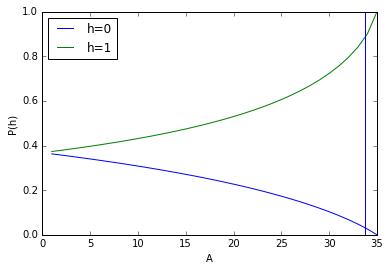

In [26]:
plt.plot(range(1,N0//2+1), [P(0, a) for a in range(1,N0//2+1)], label='h=0')
plt.plot(range(1,N0//2+1), [P(1, a) for a in range(1,N0//2+1)], label='h=1')
plt.xlabel('A')
plt.ylabel('P(h)')
plt.legend(loc='upper left')
plt.axvline((2*N0*u/tau)**(1/2))

The probability for a given monomer to hold a crosslink is thus
$$\frac{1-P(h=0)}{N_0}$$
The number of monomers betwenn crosslinks is the inverse of the latter. Finally, the number of chains between crosslinks is 
$$n = \frac{1}{1-P(h=0)}$$

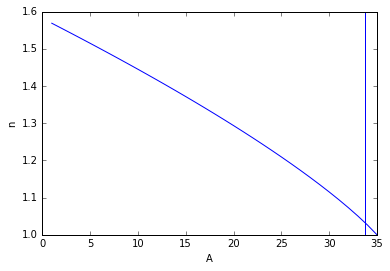

In [27]:
plt.plot(range(1,N0//2+1), [1/(1-P(0, a)) for a in range(1,N0//2+1)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))

In [28]:
1/(1-P(0))

1.5687764482632396

There is also a threshold $A_2 = \left(\frac{3N_0 u}{\tau}\right)^{1/2}$ when a dimeric side chains can collapse on the main chain. For $A>A_2$
$$n = \frac{1}{1-P(h=0)-P(h=1)P(h=0)}$$

In [29]:
1/(1-P(0) - P(0)*P(1))

1.9915434258974904

For $A>A_3$
$$n = \frac{1}{1 - P(h=0) - P(h=1)\left(P(h=0)+P(h=1)P(h=0)\right) - P(h=2)P(h=0)^2}$$

In [30]:
1/(1 - P(0)*(1 + P(1) + P(1)**2) - P(0)**2*P(2)*(1+2*P(1)))

2.4463089358439283

In [31]:
1/(1 - P(0)*(1 + P(1) + P(1)**2 + P(1)**3) - P(0)**2*P(2)*(1+2*P(1)+3*P(1)**2) - P(0)**3*P(3))

2.6539150687299284

A single head attached and thus a linear procession has probability of P(h=1)

In [32]:
binom.pmf(1, N0/2, 2/N0)

0.37322409319569066

And the probability to branch is $P(h\geq 2)$

In [33]:
1 - np.sum(binom.pmf([0,1], N0/2, 2/N0))

0.2642153591284947

Therefore, the number of chains beween cross links n=k is

In [34]:
1/(1-np.sum(binom.pmf([0,1], N0/2, 2/N0)))

3.7847913281743564

More complete expression taking into account the probability to have a second branching (third head) on the same 
$$\frac{P(h=2) \times 1/P(h\geq 2) + P(h>3)}{P(h\geq 2)}$$

In [35]:
(binom.pmf(2, N0/2, 2/N0) / (1-np.sum(binom.pmf([0,1], N0/2, 2/N0))) + (1-np.sum(binom.pmf([0,1,2], N0/2, 2/N0)))) / (1-np.sum(binom.pmf([0,1], N0/2, 2/N0)))

2.9668637387798635

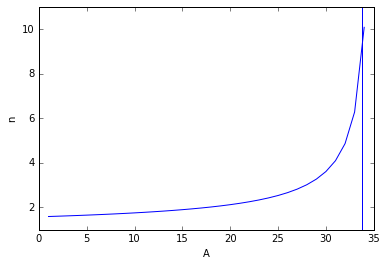

In [36]:
plt.plot(range(1,N0//2), [1/(1-P(1,a)) for a in range(1,N0//2)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))

$N_0/A$ is not actually a hard upper bound to the number of possible sites on a chain. The number of charges on a given chain follows a binomial law of mean $N_0/A$ and upper bound $N_0$. We have to combine this and the previous law giving the probability distribution of the number of heads knowing the number of charges.
$$P(h,A) = \sum_{i=0}^{N_0} P(h|i)P(i,A)$$

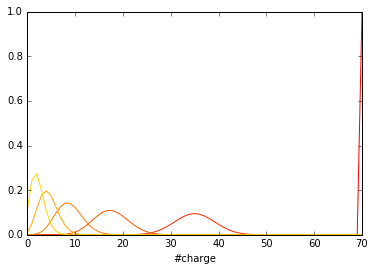

In [37]:
for a in 2**np.arange(6):
    plt.plot(np.arange(N0+1), binom.pmf(np.arange(N0+1), N0, 1/a), color=plt.cm.autumn(np.log2(a)/6))
plt.xlabel('#charge')

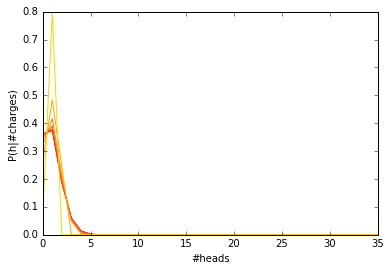

In [38]:
i=70
for i in N0/2**np.arange(6):
    plt.plot(range(N0//2+1), binom.pmf(np.arange(N0//2+1), i/2, 2/i), color=plt.cm.autumn(np.log2(N0/i)/6))
plt.xlabel('#heads')
plt.ylabel('P(h|#charges)')

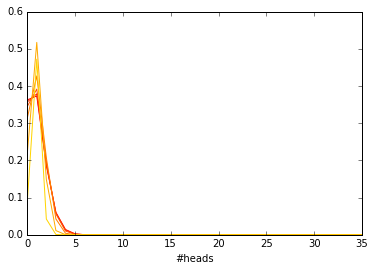

In [39]:
for a in 2**np.arange(6):
    Pcharges = binom.pmf(np.arange(2,N0+1), N0, 1/a)
    plt.plot(
        range(N0//2+1), 
        [np.sum(Pcharges * np.array([binom.pmf(h, i/2, 2/i) for i in range(2,N0+1)])) for h in range(N0//2+1)],
        color=plt.cm.autumn(np.log2(a)/6)
    )
plt.xlabel('#heads')

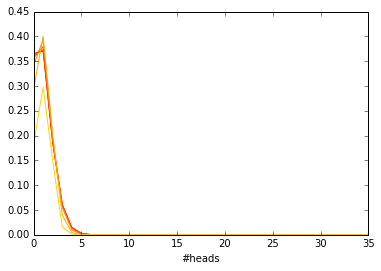

In [40]:
for a in 2**np.arange(6):
    Pcharges = binom.pmf(np.arange(2,N0+1), N0, 1/a)
    plt.plot(
        range(N0//2+1), 
        [np.sum(Pcharges * np.array([binom.pmf(h, i, 1/i) for i in range(2,N0+1)])) for h in range(N0//2+1)],
        color=plt.cm.autumn(np.log2(a)/6)
    )
plt.xlabel('#heads')

In [41]:
def P(h, A=1):
    Pcharges = binom.pmf(np.arange(1,N0+1), N0, 1/A)
    Pheads = np.array([binom.pmf(h, i/1, 1/i) for i in range(1,N0+1)])
    return np.sum(Pheads * Pcharges, -1)

In [42]:
P(0)

0.36523597711796002

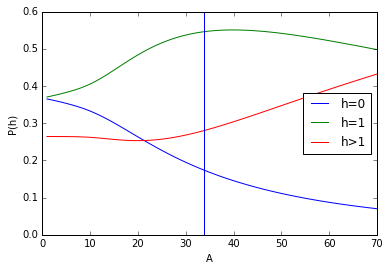

In [43]:
plt.plot(range(1,N0+1), [P(0, a) for a in range(1,N0+1)], label='h=0')
plt.plot(range(1,N0+1), [P(1, a) for a in range(1,N0+1)], label='h=1')
plt.plot(range(1,N0+1), [1-P(0,a)-P(1, a) for a in range(1,N0+1)], label='h>1')
plt.xlabel('A')
plt.ylabel('P(h)')
plt.legend(loc='center right')
plt.axvline((2*N0*u/tau)**(1/2))

(0, 2.5)

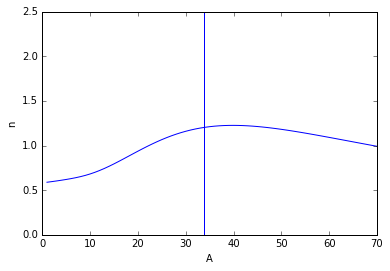

In [44]:
plt.plot(range(1,N0+1), [1/(1-P(1,a))-1 for a in range(1,N0+1)])
plt.xlabel('A')
plt.ylabel('n')
plt.axvline((2*N0*u/tau)**(1/2))
plt.ylim(0,2.5)

Probability to have 2 neighbouring charges for a given A.

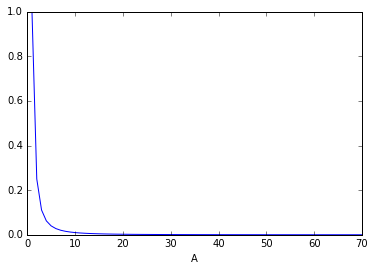

In [45]:
plt.plot(range(1,N0+1), [binom.pmf(2,2,1/a) for a in range(1,N0+1)])
plt.xlabel('A')

Distance beween two couples of neighbouring charges function of A

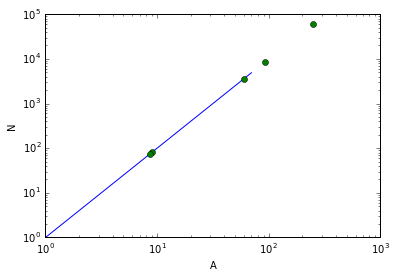

In [46]:
plt.plot(range(1,N0+1), [1/binom.pmf(2,2,1/a) for a in range(1,N0+1)])
plt.xlabel('A')
plt.ylabel('N')
plt.xscale('log')
plt.yscale('log')
plt.plot(np.sqrt(n*N0), n*N0, 'o')

In [47]:
2/N0**2

0.00040816326530612246

In [50]:
(2*u*N0/np.arange(2,11)*10)**0.5

array([ 43.41215711,  35.44587785,  30.69703068,  27.45625892,
        25.06402059,  23.20477404,  21.70607855,  20.46468712,  19.41450687])